# Importing Relevant Packages

In [ ]:
# pip install yfinance
# pip install pmdarima
# pip install --upgrade scikit-learn scikeras

In [26]:
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.append(os.path.abspath("../Scripts"))
from download_data import StockData
from preprocessing import DataPreprocessor
from eda import TeslaStockAnalysis
from build_model import ARIMAForecaster, LSTMForecaster, SARIMAForecaster

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Task 1: Preprocess and Explore the Data

### Load and Clean Data

In [28]:
tickers = ['TSLA', 'BND', 'SPY']
start_date = "2020-01-01"
end_date = "2025-01-31"

# Create instance of StockData
stock_data = StockData(tickers, start_date, end_date)

In [29]:
stock_data.download_data()

[*********************100%***********************]  3 of 3 completed


Price           Close                               High              \
Ticker            BND         SPY        TSLA        BND         SPY   
Date                                                                   
2020-01-02  72.731865  301.194916   28.684000  72.853127  301.213476   
2020-01-03  72.991714  298.914185   29.534000  73.009041  300.054558   
2020-01-06  72.905136  300.054504   30.102667  73.026399  300.137942   
2020-01-07  72.844437  299.210938   31.270666  72.931052  299.961906   
2020-01-08  72.731865  300.805511   32.809334  72.931079  302.038574   
...               ...         ...         ...        ...         ...   
2025-01-24  71.592484  607.969971  406.579987  71.642168  610.780029   
2025-01-27  71.970116  599.369995  397.149994  71.989996  599.690002   
2025-01-28  71.930367  604.520020  398.089996  71.940307  605.369995   
2025-01-29  71.890610  601.809998  389.100006  72.039679  604.130005   
2025-01-30  71.989998  605.039978  400.279999  72.079435  606.599976   

Price                         Low                               Open  \
Ticker            TSLA        BND         SPY        TSLA        BND   
Date                                                                   
2020-01-02   28.713333  72.697218  299.025448   28.114000  72.740528   
2020-01-03   30.266666  72.844468  297.699654   29.128000  72.913763   
2020-01-06   30.104000  72.853168  297.013510   29.333332  73.017742   
2020-01-07   31.441999  72.818453  298.756627   30.224001  72.931052   
2020-01-08   33.232666  72.671234  299.155231   31.215334  72.870448   
...                ...        ...         ...         ...        ...   
2025-01-24  418.880005  71.423541  606.799988  405.779999  71.552731   
2025-01-27  406.690002  71.811114  594.640015  389.000000  71.890611   
2025-01-28  400.589996  71.761424  597.250000  386.500000  71.940307   
2025-01-29  398.589996  71.721668  599.219971  384.480011  71.980055   
2025-01-30  412.500000  71.930365  600.719971  384.410004  72.009870   

Price                                Volume                       
Ticker             SPY        TSLA      BND       SPY       TSLA  
Date                                                              
2020-01-02  299.961853   28.299999  5511000  59151200  142981500  
2020-01-03  297.755279   29.366667  5368300  77709700  266677500  
2020-01-06  297.134040   29.364668  3710400  55653900  151995000  
2020-01-07  299.479783   30.760000  3029900  40496400  268231500  
2020-01-08  299.405545   31.580000  3674400  68296000  467164500  
...                ...         ...      ...       ...        ...  
2025-01-24  609.809998  414.450012  5555700  34604700   56427100  
2025-01-27  594.809998  394.799988  8621200  70361100   58125500  
2025-01-28  600.619995  396.910004  4424300  44433300   48910700  
2025-01-29  603.719971  395.209991  5780200  37177400   68033600  
2025-01-30  603.960022  410.779999  5622300  39281300   98092900  

[1277 rows x 15 columns]

In [30]:
close_df, high_df, low_df, open_df, volume_df = stock_data.extract_price_categories()

In [31]:
close_df, high_df, low_df, open_df, volume_df = stock_data.reset_indexes()

In [32]:
close_df, high_df, low_df, open_df, volume_df = stock_data.melt_data()

### Alternatively I can run it only using this

In [47]:
# Process the data
stock_data.process_data()

[*********************100%***********************]  3 of 3 completed


In [33]:
# Get the merged DataFrame
stock_data.merge_data()
df_merged = stock_data.get_merged_data()

In [10]:
df_merged.head()

,Date,Ticker,Open,Low,Volume,High,Close
0,2020-01-02,TSLA,28.299999,28.114000,142981500,28.713333,28.684000
1,2020-01-03,TSLA,29.366667,29.128000,266677500,30.266666,29.534000
2,2020-01-06,TSLA,29.364668,29.333332,151995000,30.104000,30.102667
3,2020-01-07,TSLA,30.760000,30.224001,268231500,31.441999,31.270666
4,2020-01-08,TSLA,31.580000,31.215334,467164500,33.232666,32.809334


In [13]:
data = df_merged[['Date','Close']][df_merged['Ticker'] == 'TSLA']

In [14]:
data.to_csv('tsla.csv', index=False)

In [35]:
data = df_merged

In [15]:
data.Ticker.value_counts()

Ticker
TSLA    1277
BND     1277
SPY     1277
Name: count, dtype: int64

In [36]:
tsla = data[(data.Ticker=='TSLA')]

## Preprocessing

In [ ]:
# Initialize the preprocessor
preprocessor = DataPreprocessor(tsla)

### Handling Duplicates

In [40]:
# Apply data cleaning and transformation steps
preprocessor.handle_duplicates()

Removed 0 duplicate rows.


### Handle Missing Values

In [41]:
preprocessor.handle_missing_values()

Filled 0 missing values.


### Check Outlier

In [42]:
preprocessor.check_outliers()

Outlier count per column: {'Open': 80, 'Low': 77, 'Volume': 92, 'High': 81, 'Close': 83}


### Check Datatypes

In [43]:
preprocessor.check_data_types()


Data Types:
 Date      datetime64[ns]
Ticker            object
Open             float64
Low              float64
Volume             int64
High             float64
Close            float64
dtype: object


### Data Normalization

In [44]:
# Processed Data
processed_data = preprocessor.Normalized_data()
processed_data.head()

,Open,Low,Volume,High,Close,Date
0,0.007363,0.010933,0.128385,0.003732,0.010098,2020-01-02
1,0.009728,0.013269,0.268205,0.007098,0.011963,2020-01-03
2,0.009724,0.013742,0.138573,0.006745,0.013211,2020-01-06
3,0.012818,0.015794,0.269962,0.009644,0.015774,2020-01-07
4,0.014637,0.018077,0.494826,0.013524,0.019150,2020-01-08


### Exploratory Data Analysis (EDA)

In [75]:
# Sort index to ensure chronological order
df = processed_data

In [77]:
for_lstm = df

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

# Set 'Date' as the index
df = df.set_index('Date')

# Sort by the new index
df = df.sort_index()


In [49]:
grid_data = df

In [50]:
grid_data.head()

,Open,Low,Volume,High,Close
Date,,,,,
2020-01-02,0.007363,0.010933,0.128385,0.003732,0.010098
2020-01-03,0.009728,0.013269,0.268205,0.007098,0.011963
2020-01-06,0.009724,0.013742,0.138573,0.006745,0.013211
2020-01-07,0.012818,0.015794,0.269962,0.009644,0.015774
2020-01-08,0.014637,0.018077,0.494826,0.013524,0.019150


In [30]:
# Initialize the analysis class
ts_analysis = TeslaStockAnalysis(df)

### Visualize Closing Prices

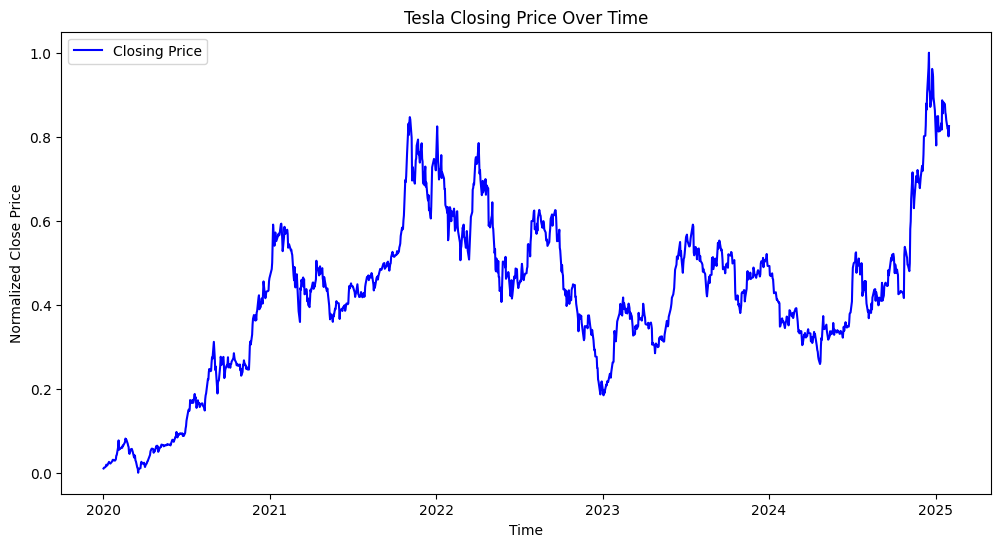

In [103]:
# Run Exploratory Data Analysis
ts_analysis.plot_closing_price()

### Calculate Daily Returns

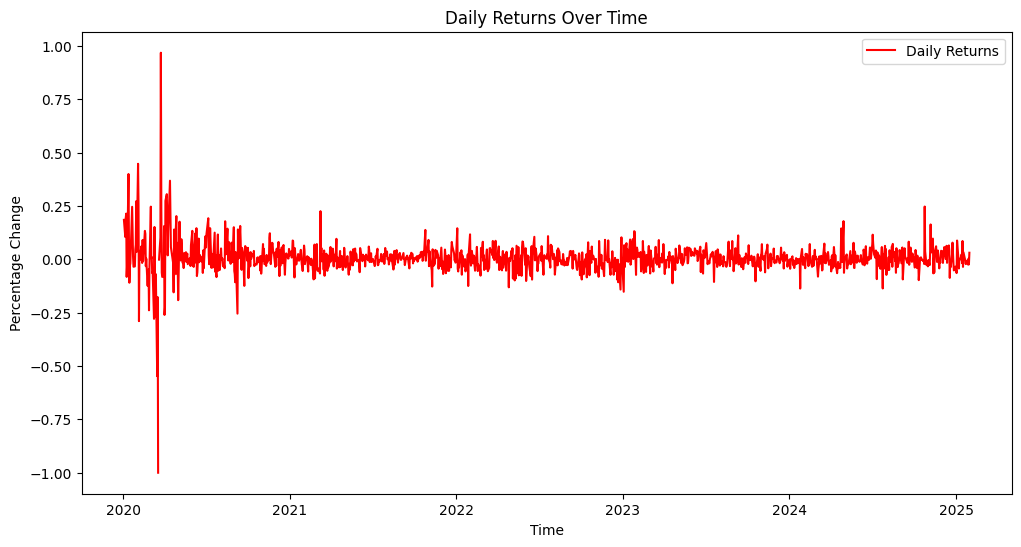

In [104]:
ts_analysis.calculate_daily_returns()

In [105]:
outliers = ts_analysis.detect_outliers()

Identified 22 outlier days with extreme returns.


In [106]:
outliers

,Date,Open,Low,Volume,High,Close,Daily Returns,Z-Score
7,2020-01-13,0.017564,0.021727,0.416379,0.017444,0.023936,0.399470,5.430545
12,2020-01-21,0.022997,0.027318,0.268629,0.020759,0.027203,0.245847,3.316523
19,2020-01-30,0.038103,0.041076,0.458565,0.035535,0.040896,0.272194,3.679089
21,2020-02-03,0.044204,0.049601,0.764766,0.055072,0.061255,0.447313,6.088923
22,2020-02-04,0.075144,0.074226,1.000000,0.081484,0.076915,0.255647,3.451390
23,2020-02-05,0.066318,0.054299,0.787805,0.063716,0.054629,-0.289746,-4.053834
38,2020-02-27,0.052530,0.048907,0.378392,0.048375,0.046482,-0.238996,-3.355459
40,2020-03-02,0.049759,0.051621,0.309177,0.048941,0.055934,0.246537,3.326017
45,2020-03-09,0.034107,0.039079,0.256255,0.037286,0.036096,-0.278969,-3.905534
48,2020-03-12,0.030484,0.030058,0.287375,0.027392,0.029156,-0.269880,-3.780461


### Decompose Tesla’s Stock Price (Trend, Seasonality, Residuals)

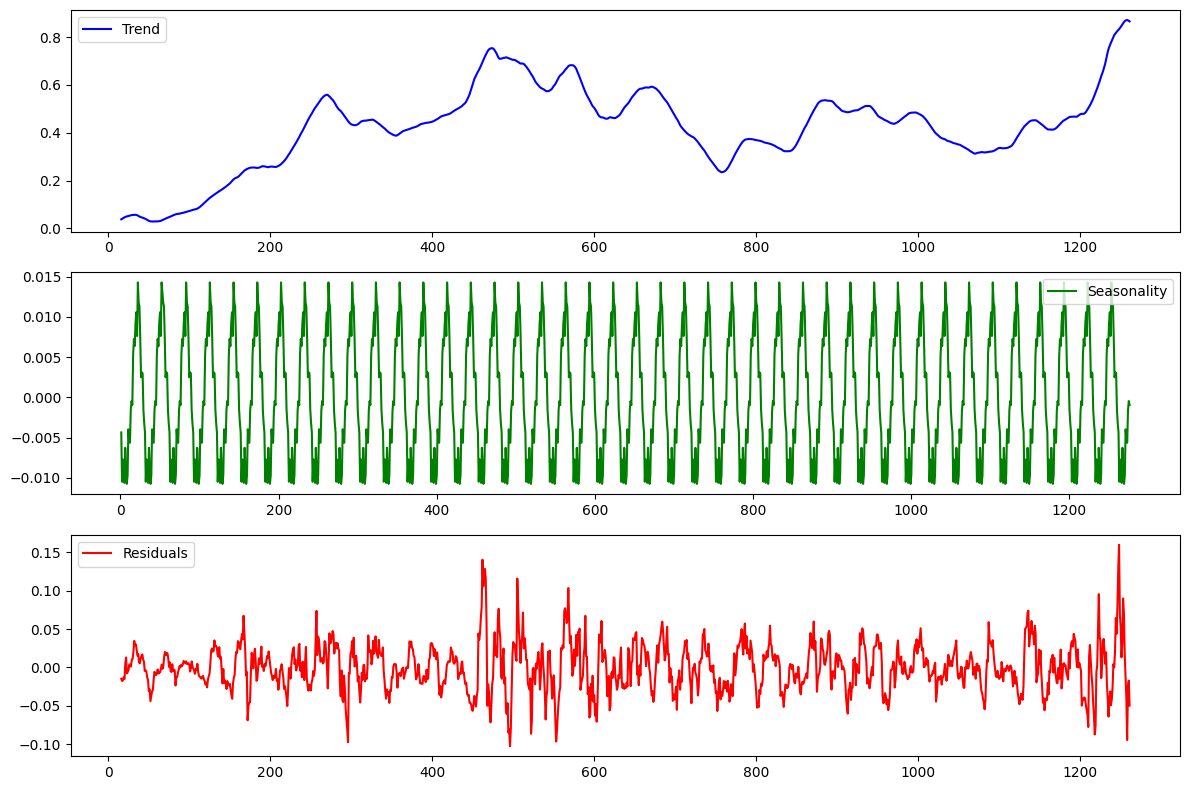

In [107]:
# Perform Trend & Seasonality Analysis
ts_analysis.decompose_time_series()

### Rolling Volatility (Standard Deviation)

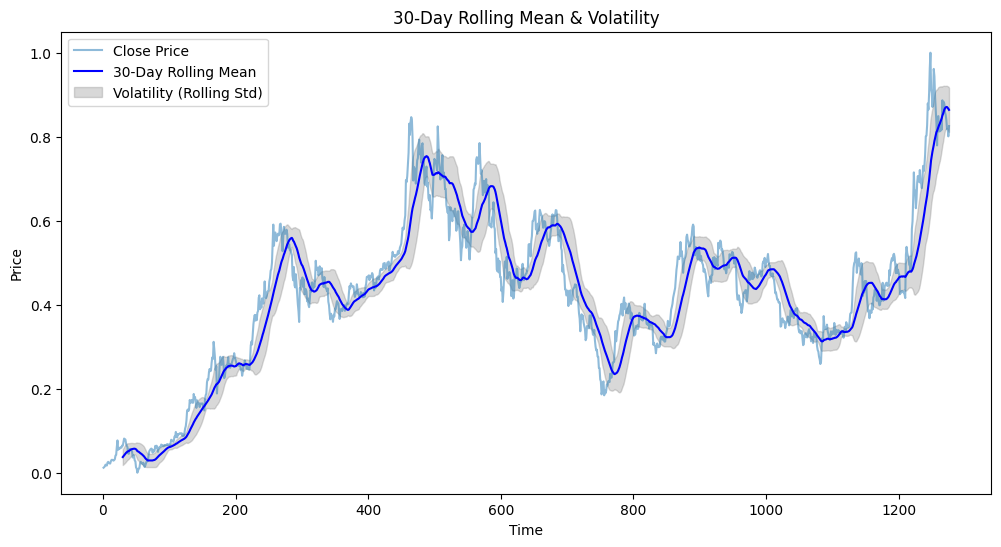

In [108]:
# Analyze Volatility & Risk
ts_analysis.rolling_volatility_analysis(window=30)

In [109]:
ts_analysis.risk_analysis()

VaR (95% confidence): -0.1151
Sharpe Ratio: 0.0666


## Task 2: Develop Time Series Forecasting Models

### Prepare Data for Forecasting

### Train Test Split

In [22]:
data = df["Close"]
train_size = int(len(data) * 0.9)
train, test = data[:train_size], data[train_size:]

### Train ARIMA Model

In [62]:
# ARIMA Model
arima_forecaster = ARIMAForecaster(train)
arima_forecaster.train_model()


### Forecast Using ARIMA

In [65]:
arima_predictions, _ = arima_forecaster.forecast(steps=len(test))
arima_metrics = arima_forecaster.evaluate(test)
print("ARIMA Evaluation:", arima_metrics)

ARIMA Evaluation: {'MAE': 0.18324789705461875, 'RMSE': 0.25533124695991366, 'MAPE': 23.262877329528045, 'R Squered:': -0.8585202573467923}


In [66]:
arima_forecaster.predict_future()

(2024-07-29    0.429935
 2024-07-30    0.429527
 2024-07-31    0.429847
 2024-08-01    0.429596
 2024-08-02    0.429793
 2024-08-05    0.429638
 2024-08-06    0.429760
 2024-08-07    0.429664
 2024-08-08    0.429740
 2024-08-09    0.429680
 2024-08-12    0.429727
 2024-08-13    0.429690
 2024-08-14    0.429719
 2024-08-15    0.429697
 2024-08-16    0.429714
 2024-08-19    0.429700
 2024-08-20    0.429711
 2024-08-21    0.429703
 2024-08-22    0.429709
 2024-08-23    0.429704
 2024-08-26    0.429708
 2024-08-27    0.429705
 2024-08-28    0.429708
 2024-08-29    0.429706
 2024-08-30    0.429707
 2024-09-02    0.429706
 2024-09-03    0.429707
 2024-09-04    0.429706
 2024-09-05    0.429707
 2024-09-06    0.429706
 2024-09-09    0.429707
 2024-09-10    0.429706
 2024-09-11    0.429707
 2024-09-12    0.429706
 2024-09-13    0.429707
 2024-09-16    0.429706
 2024-09-17    0.429707
 2024-09-18    0.429706
 2024-09-19    0.429707
 2024-09-20    0.429706
 2024-09-23    0.429706
 2024-09-24    0

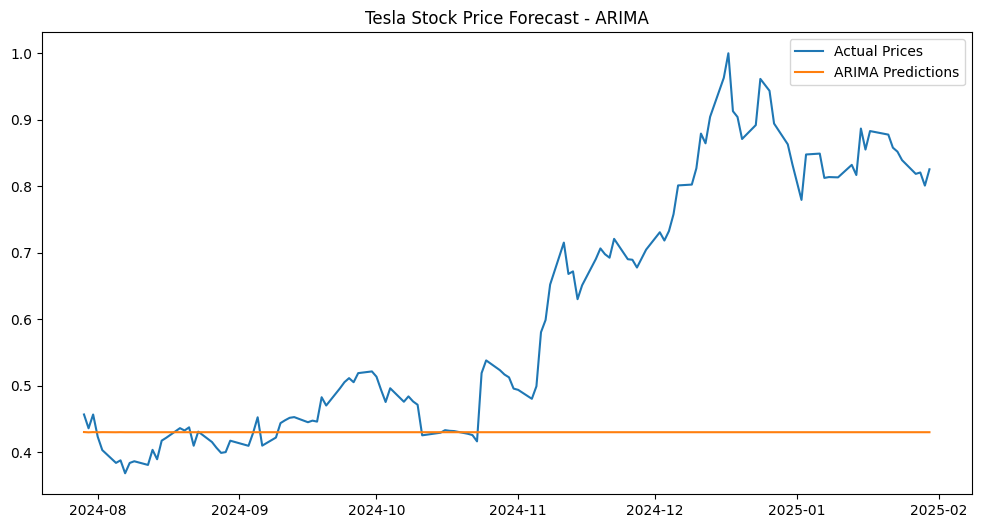

In [98]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label="Actual Prices")
plt.plot(test.index, arima_predictions, label="ARIMA Predictions")
plt.legend()
plt.title("Tesla Stock Price Forecast - ARIMA")
plt.show()

### Train SARIMA Model

In [99]:
# SARIMA Model
sarima_forecaster = SARIMAForecaster(train)
sarima_forecaster.train_model()

### Forecast Using SARIMA

In [100]:
sarima_predictions, _ = sarima_forecaster.forecast(steps=len(test))
sarima_metrics = sarima_forecaster.evaluate(test)
print("SARIMA Evaluation:", sarima_metrics)

SARIMA Evaluation: {'MAE': 0.16147216562697578, 'RMSE': 0.2277431989633405, 'MAPE': 21.627162317402533, 'R-squared': -0.4852005894995237}


In [101]:
sarima_forecaster.predict_future()

(2024-07-27    0.433310
 2024-07-28    0.433408
 2024-07-29    0.431763
 2024-07-30    0.432303
 2024-07-31    0.434231
 2024-08-01    0.431788
 2024-08-02    0.432477
 2024-08-03    0.434186
 2024-08-04    0.431199
 2024-08-05    0.429752
 2024-08-06    0.430888
 2024-08-07    0.433017
 2024-08-08    0.436497
 2024-08-09    0.436478
 2024-08-10    0.434802
 2024-08-11    0.435333
 2024-08-12    0.437258
 2024-08-13    0.434815
 2024-08-14    0.435503
 2024-08-15    0.437212
 2024-08-16    0.434225
 2024-08-17    0.432778
 2024-08-18    0.433914
 2024-08-19    0.436043
 2024-08-20    0.439523
 2024-08-21    0.439504
 2024-08-22    0.437827
 2024-08-23    0.438358
 2024-08-24    0.440284
 2024-08-25    0.437840
 2024-08-26    0.438529
 2024-08-27    0.440238
 2024-08-28    0.437251
 2024-08-29    0.435804
 2024-08-30    0.436940
 2024-08-31    0.439069
 2024-09-01    0.442548
 2024-09-02    0.442530
 2024-09-03    0.440853
 2024-09-04    0.441384
 2024-09-05    0.443309
 2024-09-06    0

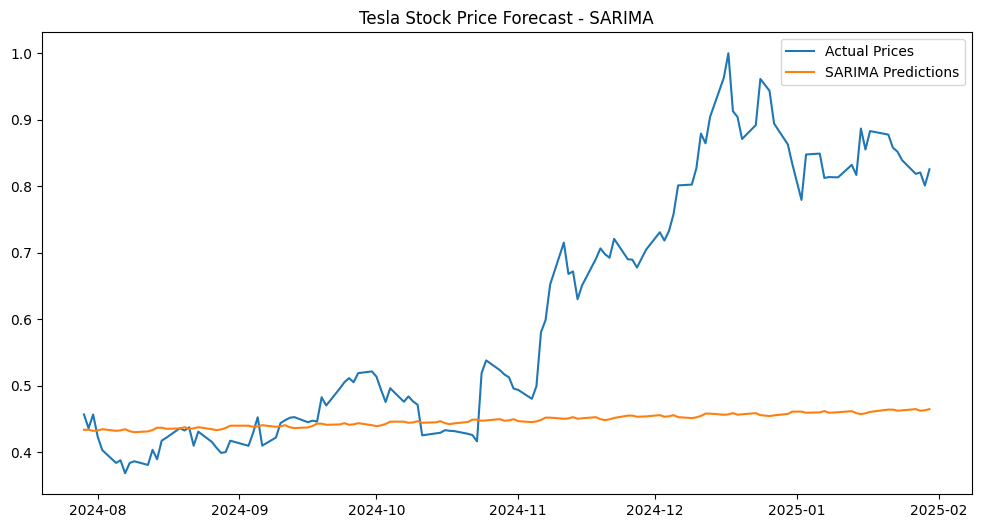

In [102]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label="Actual Prices")
plt.plot(test.index, sarima_predictions, label="SARIMA Predictions")
plt.legend()
plt.title("Tesla Stock Price Forecast - SARIMA")
plt.show()

### Train LSTM Model

In [24]:
 # LSTM Model
lstm_forecaster = LSTMForecaster(train)
lstm_forecaster.train_model()

Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - loss: 0.0594
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - loss: 0.0088
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - loss: 0.0059
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - loss: 0.0048
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0040
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - loss: 0.0040
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - loss: 0.0041
Epoch 8/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - loss: 0.0035
Epoch 9/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.0032
Epoch 10/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0036
Epoch 11/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - loss: 0.0036
Epoch 12/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - loss: 0.0034
Epoch 13/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - loss: 0.0029
Epoch 14/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.0037
Epoch 15/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0

### Forecast Using LSTM

In [59]:
# pip install --upgrade scikit-learn scikeras tensorflow keras

In [71]:
grid_data.head()

,Open,Low,Volume,High,Close
Date,,,,,
2020-01-02,0.007363,0.010933,0.128385,0.003732,0.010098
2020-01-03,0.009728,0.013269,0.268205,0.007098,0.011963
2020-01-06,0.009724,0.013742,0.138573,0.006745,0.013211
2020-01-07,0.012818,0.015794,0.269962,0.009644,0.015774
2020-01-08,0.014637,0.018077,0.494826,0.013524,0.019150


In [39]:
data = pd.read_csv('tsla.csv')
data.head()

,Date,Close
0,2020-01-02,28.684000
1,2020-01-03,29.534000
2,2020-01-06,30.102667
3,2020-01-07,31.270666
4,2020-01-08,32.809334


In [54]:
%load_ext autoreload
%autoreload 2
from grid_search import LSTMForecaster

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
df = data["Close"]
train_size = int(len(df) * 0.9)
train, test = df[:train_size], df[train_size:]

In [17]:
# Convert the 'Date' column to datetime
data.loc[:, 'Date'] = pd.to_datetime(data['Date'])


# Initialize and train the LSTM model
forecaster = LSTMForecaster(data)
forecaster.train_model(batch_size=32, dropout_rate=0.2, epochs=20, lstm_units=100)

# Save the trained model (done inside train_model)

# Forecast future values using the trained model
forecast_steps = 10
forecast = forecaster.forecast(steps=forecast_steps)
print("Forecasted values:", forecast)

c:\Users\Admin\.pyenv\pyenv-win\versions\3.10.11\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - loss: 0.0557
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - loss: 0.0049
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - loss: 0.0045
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - loss: 0.0052
Epoch 5/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - loss: 0.0034
Epoch 6/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - loss: 0.0093
Epoch 7/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - loss: 0.0040
Epoch 8/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - loss: 0.0029
Epoch 9/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - loss: 0.0026
Epoch 10/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - loss: 0.0029
Epoch 11/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - loss: 0.0023
Epoch 12/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - loss: 0.0032
Epoch 13/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - loss: 0.0022
Epoch 14/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - loss: 0.0026
Epoch 15/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - loss:

Forecasted values: [393.57922 389.07867 385.96597 383.79996 382.22662 381.01862 380.04996
 379.25504 378.597   378.04968]


In [18]:
# Load the saved model for future predictions (optional)
loaded_model = forecaster.load_trained_model(model_path='lstm_model.h5')

## Task 3: Forecast Future Market Trends

In [19]:
# Example of forecasting with the loaded model
forecast_from_loaded_model = forecaster.forecast(steps=forecast_steps)
print("Forecast from loaded model:", forecast_from_loaded_model)

Forecast from loaded model: [393.57922 389.07867 385.96597 383.79996 382.22662 381.01862 380.04996
 379.25504 378.597   378.04968]


In [20]:
# Forecast the next day
next_day, next_day_forecast = forecaster.forecast_next_day()
print(f"Forecast for the next day ({next_day}): {next_day_forecast}")

Forecast for the next day (2025-03-05): 393.5792236328125


In [21]:
# Forecast the next 30 days
next_30_days = forecaster.forecast_next_30_days()
print("Forecast for the next 30 days:")
for date, forecast in next_30_days:
    print(f"{date}: {forecast}")

Forecast for the next 30 days:
2025-03-05: 393.5792236328125
2025-03-06: 389.07867431640625
2025-03-07: 385.9659729003906
2025-03-08: 383.7999572753906
2025-03-09: 382.22662353515625
2025-03-10: 381.01861572265625
2025-03-11: 380.0499572753906
2025-03-12: 379.2550354003906
2025-03-13: 378.59698486328125
2025-03-14: 378.0496826171875
2025-03-15: 377.58831787109375
2025-03-16: 377.1888122558594
2025-03-17: 376.8278503417969
2025-03-18: 376.4850158691406
2025-03-19: 376.1432800292969
2025-03-20: 375.7899169921875
2025-03-21: 375.41680908203125
2025-03-22: 375.018798828125
2025-03-23: 374.5940856933594
2025-03-24: 374.1432189941406
2025-03-25: 373.6686096191406
2025-03-26: 373.17376708984375
2025-03-27: 372.66259765625
2025-03-28: 372.1397705078125
2025-03-29: 371.6097106933594
2025-03-30: 371.0766906738281
2025-03-31: 370.54425048828125
2025-04-01: 370.0158996582031
2025-04-02: 369.494140625
2025-04-03: 368.98138427734375


In [22]:
# Forecast for a selected date range (e.g., 2020-01-10 to 2020-01-15)
selected_date_range = forecaster.forecast_selected_date(start_date='2020-01-10', end_date='2020-01-15')
print("Forecast for selected date range:")
for date, forecast in selected_date_range:
    print(f"{date}: {forecast}")

Forecast for selected date range:
2020-01-10: 393.5792236328125
2020-01-11: 389.07867431640625
2020-01-12: 385.9659729003906
2020-01-13: 383.7999572753906
2020-01-14: 382.22662353515625
2020-01-15: 381.01861572265625


In [23]:
# Evaluate and forecast the next 30 days after training and evaluation
forecast_30_days = forecaster.evaluate_and_forecast(test_size=0.2, batch_size=32, dropout_rate=0.2, epochs=20, lstm_units=100)


Epoch 1/20


c:\Users\Admin\.pyenv\pyenv-win\versions\3.10.11\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - loss: 0.0618
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0076
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 0.0072
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.0050
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 0.0056
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0055
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0047
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.0078 
Epoch 9/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - loss: 0.0040 
Epoch 10/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0036
Epoch 11/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 0.0035
Epoch 12/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 0.0038
Epoch 13/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - loss: 0.0033
Epoch 14/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - loss: 0.0092
Epoch 15/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - loss: 0.0096
Epoch 

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step
Mean Absolute Error (MAE): 11.343935602289333
Mean Squared Error (MSE): 238.02102175291478
Root Mean Squared Error (RMSE): 15.427929924423262
R-squared (R²): 0.9592032533023888


In [24]:
forecast_30_days

[('2025-03-05', 211.87663),
 ('2025-03-06', 210.37035),
 ('2025-03-07', 209.56091),
 ('2025-03-08', 209.26158),
 ('2025-03-09', 209.28642),
 ('2025-03-10', 209.49234),
 ('2025-03-11', 209.78465),
 ('2025-03-12', 210.10686),
 ('2025-03-13', 210.428),
 ('2025-03-14', 210.73242),
 ('2025-03-15', 211.0123),
 ('2025-03-16', 211.26381),
 ('2025-03-17', 211.48526),
 ('2025-03-18', 211.67627),
 ('2025-03-19', 211.8373),
 ('2025-03-20', 211.96976),
 ('2025-03-21', 212.07565),
 ('2025-03-22', 212.15753),
 ('2025-03-23', 212.21837),
 ('2025-03-24', 212.2612),
 ('2025-03-25', 212.28912),
 ('2025-03-26', 212.30513),
 ('2025-03-27', 212.3118),
 ('2025-03-28', 212.31157),
 ('2025-03-29', 212.30663),
 ('2025-03-30', 212.2986),
 ('2025-03-31', 212.28908),
 ('2025-04-01', 212.279),
 ('2025-04-02', 212.26933),
 ('2025-04-03', 212.26067)]

In [54]:
lstm_predictions = lstm_forecaster.forecast(steps=len(test))
lstm_metrics = lstm_forecaster.evaluate(test)
print("LSTM Evaluation:", lstm_metrics)

LSTM Evaluation: {'MAE': 0.15598127858725325, 'RMSE': 0.17873004302939952, 'MAPE': 31.822194965372397, 'R Squared': 0.0893437206379254}


In [50]:
data

,Date,Close
0,2020-01-02,28.684000
1,2020-01-03,29.534000
2,2020-01-06,30.102667
3,2020-01-07,31.270666
4,2020-01-08,32.809334
...,...,...
1272,2025-01-24,406.579987
1273,2025-01-27,397.149994
1274,2025-01-28,398.089996
1275,2025-01-29,389.100006


In [76]:
df_sample = data.sample(frac=0.1, random_state=42)  # 10% random rows

### Forecast Analysis

In [78]:
predictions = forecaster.predict_test_data(df_sample)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


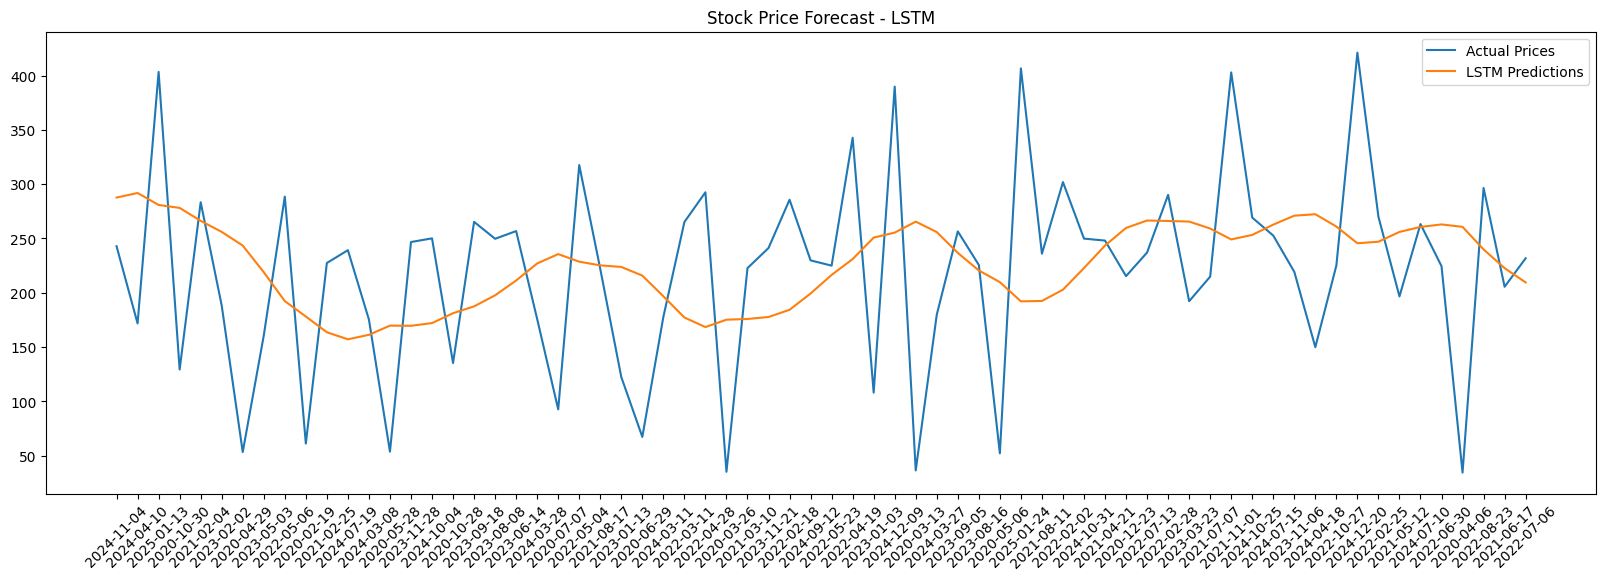

In [81]:
# Plot results
time_steps = 60
aligned_test_index = df_sample.Date[time_steps:]

plt.figure(figsize=(20, 6))
plt.plot(aligned_test_index, df_sample['Close'][time_steps:], label="Actual Prices")
plt.plot(aligned_test_index, predictions, label="LSTM Predictions")

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45)

plt.legend()
plt.title("Stock Price Forecast - LSTM")
plt.show()


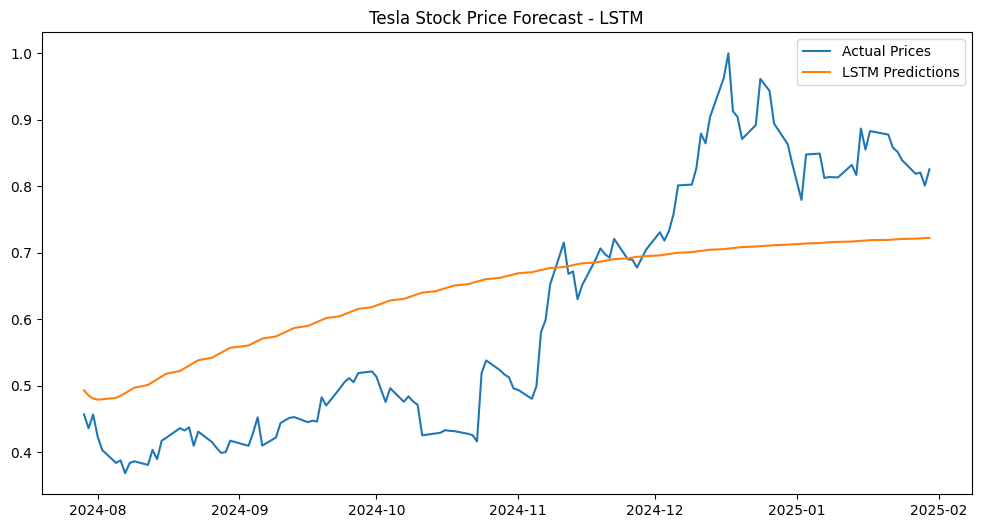

In [125]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label="Actual Prices")
plt.plot(test.index, lstm_predictions, label="LSTM Predictions")
plt.legend()
plt.title("Tesla Stock Price Forecast - LSTM")
plt.show()

In [126]:
lstm_forecaster.predict_future()

array([0.49274936, 0.48495385, 0.48035285, 0.4786896 , 0.47930044,
       0.4814824 , 0.48465386, 0.48839727, 0.49244216, 0.49662843,
       0.5008685 , 0.50511795, 0.50935495, 0.5135677 , 0.5177487 ,
       0.5218914 , 0.5259898 , 0.53003806, 0.5340312 , 0.53796494,
       0.54183644, 0.54564404, 0.5493869 , 0.55306524, 0.55667967,
       0.56023157, 0.56372255, 0.5671543 , 0.570529  , 0.5738482 ,
       0.57711405, 0.5803279 , 0.5834918 , 0.5866069 , 0.58967465,
       0.59269583, 0.59567195, 0.59860337, 0.6014909 , 0.60433507,
       0.6071362 , 0.6098951 , 0.6126113 , 0.61528563, 0.6179178 ,
       0.62050825, 0.6230571 , 0.6255644 , 0.62803   , 0.6304549 ,
       0.6328381 , 0.63518   , 0.6374811 , 0.6397415 , 0.641961  ,
       0.6441401 , 0.64627886, 0.6483778 , 0.650437  , 0.65245694],
      dtype=float32)

In [ ]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label="Actual Prices")
plt.plot(test.index, arima_predictions, label="ARIMA Predictions")
plt.plot(test.index, sarima_predictions, label="SARIMA Predictions")
plt.plot(test.index, lstm_predictions, label="LSTM Predictions")
plt.plot(aligned_test_index, predictions, label="LSTM Predictions")
plt.legend()
plt.title("Tesla Stock Price Forecast - ARIMA vs LSTM")
plt.show()

## Task 4: Optimize Portfolio Based on Forecast

### Portfolio Simulation